Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow_dynamics as tfd

In [ ]:
import gc
import itertools
import math
import numpy as np
import tensorflow as tf
import time

In [4]:
from IPython.display import display, Markdown
from matplotlib import pyplot as plt

In [5]:
tf.keras.backend.set_floatx('float64')

# Define the Experiment Loop

In [6]:
t_0 = tf.zeros([1,], dtype=tf.float64)
t_f = tf.ones([1,], dtype=tf.float64) * 2.
time_range = tf.linspace(t_0, t_f, 65)
tfd_time_range = tf.transpose(time_range, [1, 0])

In [7]:
def generate_training_data(traj_count):
    r1 = 1.
    r2 = 2.
    r3 = 3.

    gx_min1_polar = tf.random.uniform([traj_count, 2], minval=[0., 0.], maxval=[r1, 2*math.pi], dtype=tf.float64)
    gx_1_polar = tf.random.uniform([traj_count, 2], minval=[r2, 0.], maxval=[r3, 2*math.pi], dtype=tf.float64)

    gx_min1 = tf.stack([gx_min1_polar[..., 0] * tf.math.cos(gx_min1_polar[..., 1]),
                        gx_min1_polar[..., 0] * tf.math.sin(gx_min1_polar[..., 1])],
                       axis=-1)
    gx_1 = tf.stack([gx_1_polar[..., 0] * tf.math.cos(gx_1_polar[..., 1]),
                     gx_1_polar[..., 0] * tf.math.sin(gx_1_polar[..., 1])],
                    axis=-1)
    
    x = tf.concat([gx_min1, gx_1], axis=0)
    y = tf.cast(tf.concat([[-1,]*traj_count, [1,]*traj_count], axis=0), dtype=tf.float64)
    return x, y

In [8]:
class NodeClassifier(tf.keras.Model):
    def __init__(self, node):
        super().__init__()
        self._node = node
        self._linear_transform = tfd.models.layers.LinearTransform(1)
        
    def call(self, x):
        x = self._node(x)
        return self._linear_transform(x)

In [ ]:
def experiment(dxdt, terminal_loss, continuous_loss, eval_loss, encoder, decoder,
               epochs=300, lr=1e-3, traj_count=1000, eval_traj_count=200, solver="dopri5", solver_args=None,
               batch_size=1000, adjoint=True, plot_rate=30):
    solver_args = solver_args or dict(rtol=1e-3, atol=1e-3)
    encoder = encoder or tf.identity
    decoder = decoder or tf.identity
        
    # generate the training data to train on and plot the flow field
    batch_x, batch_y = generate_training_data(traj_count+eval_traj_count)
    eval_batch_x = batch_x[-eval_traj_count:, ...]
    eval_batch_y = batch_y[-eval_traj_count:, ...]
    batch_x = batch_x[:eval_traj_count, ...]
    batch_y = batch_y[:eval_traj_count, ...]
    
    # build tensorflow training set and model
    dataset = tf.data.Dataset.from_tensor_slices((batch_x, batch_y))
    dataset = dataset.shuffle(traj_count, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    
    node = tfd.models.node.BaseNODE(dx_dt=dxdt, encoder=encoder, decoder=decoder,
                                    t_eval=tfd_time_range,
                                    method=solver, options=solver_args, use_adjoint=adjoint,
                                    adjoint_options=solver_args)
    learning_solver = NodeClassifier(node)
    
    # touch the learning model
    learning_solver(batch_x[:batch_size, ...])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    optimizer.build(learning_solver.trainable_variables)
    losses = []
    start_time_s = time.time()
    for epoch in range(epochs):
        epoch_avg_loss = []
        for x, y in dataset:
            with tf.GradientTape() as tape:
                y_hat = learning_solver(x)
                err = terminal_loss(y_hat, y)
            grads = tape.gradient(err, learning_solver.trainable_variables)
            optimizer.apply_gradients(zip(grads, learning_solver.trainable_variables))
            epoch_avg_loss.append(err)
        epoch_avg_loss = np.mean(epoch_avg_loss)
        losses.append(epoch_avg_loss)
        print(f"{epoch}: {epoch_avg_loss}")

    duration_s = time.time() - start_time_s
    print(f"Training finished. Took {duration_s:.3f} seconds.")
        
    # plot the training curve
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Epochs")
    plt.show()
    
    # run a quick evaluation
    y_hat = learning_solver(eval_batch_x)
    eval_avg_loss = eval_loss(y_hat, eval_batch_y[:, None])
    print(f"Eval loss: {eval_avg_loss:.2f}")
    
    return duration_s, eval_avg_loss

# Experiments

## Experiment Library

In [10]:
def terminal_only_loss(y_hat, y):
    return tf.reduce_mean(
        tf.linalg.norm(y_hat[..., -1, :] - y, axis=-1)
    )

In [11]:
def create_optimal_transport_loss(dxdt, lambda_1):
    def optimal_transport_loss(t, y):
        return lambda_1 * tf.linalg.norm(dxdt(y), axis=-1, keepdims=True)
    return optimal_transport_loss

In [12]:
def create_jac_norm_loss(dxdt, sample):
    def jac_norm_loss(t, y):
        with tf.GradientTape() as tape:
            dy = dxdt(t, y)[..., None]
        jac = tape.batch_jacobian(dy, y)
        return tf.norm(jac, 'fro')
    return jac_norm_loss

In [13]:
def feed_forward_model(activation='tanh', initializer=None, layers=None, out_dim=2):
    layers = layers or [16, 16]
    dense_layers = [tf.keras.layers.Dense(l, activation=activation, dtype=tf.float64,
                                          kernel_initializer=initializer) for l in layers]
    dense_layers += [tf.keras.layers.Dense(out_dim, dtype=tf.float64, kernel_initializer=initializer),]
    dxdt = tf.keras.Sequential(dense_layers)
    return dxdt

In [14]:
class DxDt(tf.keras.Model):
    def __init__(self, dxdt):
        super().__init__()
        self._dxdt = dxdt
        
    def call(self, t, x):
        return self._dxdt(x)

In [15]:
def create_model(name, activation='tanh', initializer=None, layers=None):
    if name == "node":
        dxdt = tfd.models.layers.AutonomousDxDtMLP(2, layers=layers, activation=activation, initializer=initializer)
        encoder = None
        decoder = None
    elif name == "anode":
        dxdt = tfd.models.layers.AutonomousDxDtMLP(3, layers=layers, activation=activation, initializer=initializer)
        encoder = tfd.models.layers.ZeroAugmenter(2, 1)
        decoder = tfd.models.layers.Truncate(2)
    elif name == "sonode":
        dxdt = tfd.models.layers.Autonomous2ndOrderDxDtMLP(2, layers=layers, activation=activation,
                                                           initializer=initializer)
        encoder = tfd.models.layers.MLPAugmenter(2)
        decoder = tfd.models.layers.Truncate(2)
    return dxdt, encoder, decoder

In [16]:
xavier = tf.keras.initializers.GlorotUniform(seed=0)
xavier_norm = tf.keras.initializers.GlorotNormal(seed=0)
init_random = tf.keras.initializers.RandomUniform(seed=0)
init_random_norm = tf.keras.initializers.RandomNormal(seed=0)
init_constant_0_5 = tf.keras.initializers.Constant(value=0.5)
init_constant_1 = tf.keras.initializers.Constant(value=1.)

In [17]:
epochs = 50
solver = "rk4"
solver_args=dict(h=tf.cast(1./16., tf.float64))
traj_count = 1000
eval_traj_count = 200

In [18]:
batch_sizes = [32, 64, 128]
activations = ("tanh", "relu")
initializers = {#"xavier": xavier,
                "xavier_norm": xavier_norm,
#                 "init_random": init_random,
#                 "init_random_norm": init_random_norm
}
losses = {"terminal_only": terminal_only_loss,
          #"all_states": all_states_loss
}
models = ["node",
          "anode",
          "sonode"
]
adjoints = [True, False]

# Big Grid Search


(32, 'tanh', 'xavier_norm', 'terminal_only', 'node', True)

0: 5.189169645576922
1: 4.2149706818975785
2: 3.4321793380676295
3: 2.5876611621334042
4: 1.8315510643984203
5: 1.315166333689786
6: 0.9733069935447505
7: 0.7377294906745592
8: 0.5910144872466775
9: 0.4790788407384889
10: 0.3965633349805178
11: 0.33304945059617536
12: 0.301603137618404
13: 0.27905588049089597
14: 0.23089956003734607
15: 0.20722582907173104
16: 0.1866664382004673
17: 0.166925358020823
18: 0.15279692653464344
19: 0.13957194602861464
20: 0.1298706229595367
21: 0.12899816072925296
22: 0.1291819081707897
23: 0.1070053857095288
24: 0.10743770213684438
25: 0.09834132485695608
26: 0.09118727013804782
27: 0.08707493152418558
28: 0.08124226912605079
29: 0.07335154815052704
30: 0.07762637869889502
31: 0.067281704698995
32: 0.0672752104015209
33: 0.06393957806247262
34: 0.06543371622307503
35: 0.055568571378697265
36: 0.05281318292438917
37: 0.05460149650416686
38: 0.05674795923178753
39: 0.06349475598258934
40: 0.062484

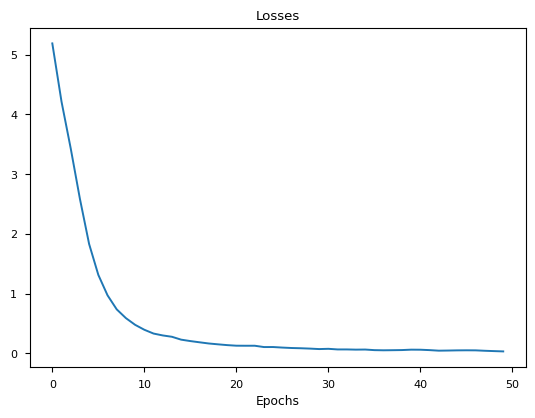

Eval loss: 1.99

(32, 'tanh', 'xavier_norm', 'terminal_only', 'node', False)

0: 5.16262074931325
1: 4.179629364372729
2: 3.025448242798833
3: 2.155162192073093
4: 1.4743659727743086
5: 1.0336477209501174
6: 0.738423486703767
7: 0.5492281139700155
8: 0.43834732614718847
9: 0.34702953030910944
10: 0.30829784665516663
11: 0.24693573721573406
12: 0.21753812339795678
13: 0.20059383127722702
14: 0.19778156989397752
15: 0.1615803136672096
16: 0.14373274574513623
17: 0.14876515238653634
18: 0.13321144776928023
19: 0.12234100780533323
20: 0.10386075233526347
21: 0.09911282854169877
22: 0.09876981225772755
23: 0.08558789831400591
24: 0.08560557041251211
25: 0.07567437648301109
26: 0.08077335035608847
27: 0.07413056472515013
28: 0.07446183430155548
29: 0.07422583878248315
30: 0.07738087166015552
31: 0.08293246725868571
32: 0.06367312917245445
33: 0.05973875472201721
34: 0.06747504816048669
35: 0.06889517206018585
36: 0.06144213763394751
37: 0.06247240216718665
38: 0.045797302171746726
39: 0.0449

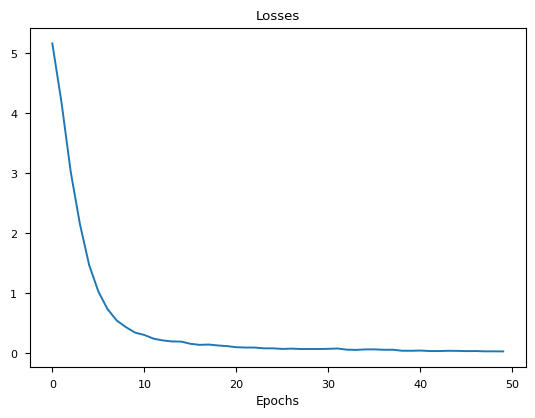

Eval loss: 2.03

(32, 'tanh', 'xavier_norm', 'terminal_only', 'anode', True)

0: 5.216553466032567
1: 4.300265227607348
2: 3.2791543563492067
3: 2.3780586008620177
4: 1.543322766419529
5: 0.764054406101401
6: 0.19903854363251433
7: 0.2286328006331626
8: 0.1223816737479009
9: 0.09453705843597181
10: 0.0790216453229006
11: 0.06538304413296483
12: 0.054049498048244056
13: 0.058285094213345996
14: 0.06324322332166396
15: 0.04184265420818323
16: 0.0388499741278205
17: 0.03339856423146563
18: 0.04291989761128477
19: 0.04145524070766593
20: 0.03291582747832974
21: 0.035623521082440525
22: 0.09184678919165445
23: 0.10085920154990854
24: 0.1344507578951696
25: 0.07950318316756526
26: 0.09804819284198489
27: 0.08985842348719074
28: 0.06480100851989183
29: 0.09209895076181067
30: 0.06889353228397464
31: 0.062455920816215656
32: 0.05496457207231537
33: 0.035642785116639354
34: 0.040415178861948786
35: 0.03192713058875994
36: 0.02728205207958492
37: 0.029493436749543595
38: 0.02547722826649321
39: 

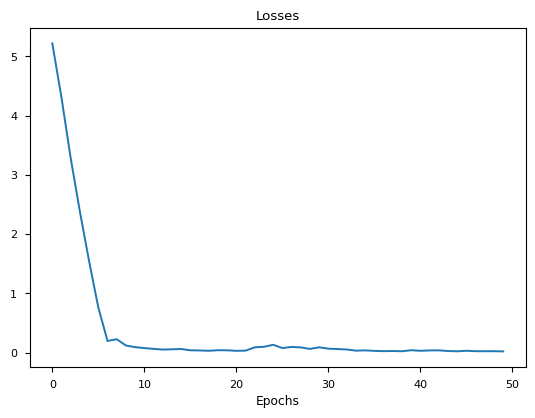

Eval loss: 1.95

(32, 'tanh', 'xavier_norm', 'terminal_only', 'anode', False)

0: 5.100757773926111
1: 4.017257237392714
2: 2.9983515849837135
3: 2.1954375820783776
4: 1.412873944484216
5: 0.6999153612120902
6: 0.18418849607717802
7: 0.2496914854186174
8: 0.11440601937461661
9: 0.10845312803325949
10: 0.05754442421272674
11: 0.07455197811607185
12: 0.045514604463345834
13: 0.031231218645996366
14: 0.03955750884389063
15: 0.04254967301099298
16: 0.06185000923150381
17: 0.03327370011943389
18: 0.03495639807688207
19: 0.03798738338021928
20: 0.03354280875505094
21: 0.03879758185137378
22: 0.04306767531711386
23: 0.031271949316899236
24: 0.035711095957430015
25: 0.023080475504411505
26: 0.04208450939835001
27: 0.05994032045428667
28: 0.05690731037429645
29: 0.07469109520427564
30: 0.053899128424178315
31: 0.04956052422702601
32: 0.03418589249062139
33: 0.04412101848480248
34: 0.0433572718735424
35: 0.06686569143503462
36: 0.07043978447674724
37: 0.05265695615454579
38: 0.03781102368137448


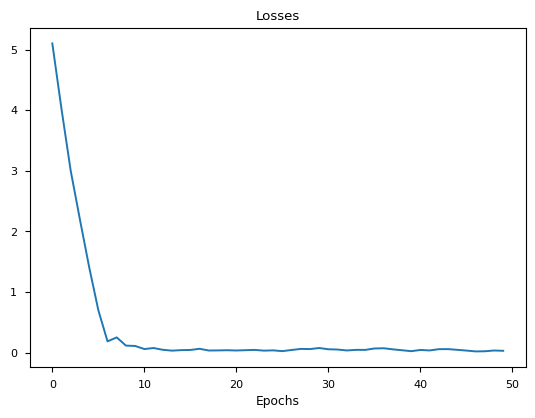

Eval loss: 2.00

(32, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 4.135493724232668
1: 2.294747713284244
2: 1.0883763836110198
3: 0.8583838455798452
4: 0.670531877212132
5: 0.47795060463413735
6: 0.3137245338035349
7: 0.1779862137156791
8: 0.11393550486618446
9: 0.12077404338365524
10: 0.10394384202993467
11: 0.07603645028369481
12: 0.07267498829563754
13: 0.07127002243445174
14: 0.07898249669189454
15: 0.07494805230808267
16: 0.09075601156857727
17: 0.07466066907118105
18: 0.0879607027081353
19: 0.09316018821008357
20: 0.0979947731823404
21: 0.08316779781305635
22: 0.07577870901789649
23: 0.08384965296072633
24: 0.09541793470687263
25: 0.10361989223386255
26: 0.07521374149946095
27: 0.09348070330596718
28: 0.12822933633670722
29: 0.06268335666198825
30: 0.042115195179214575
31: 0.06456798558034636
32: 0.07499423245725824
33: 0.0769874946349506
34: 0.04812417293675114
35: 0.06980309708051988
36: 0.07207680869015591
37: 0.056059231484595684
38: 0.03490651516898101
39: 0.

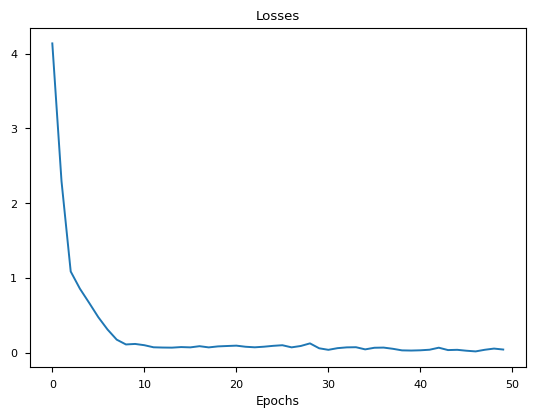

Eval loss: 2.18

(32, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 4.618121030644315
1: 2.5298579334614275
2: 1.012804433472494
3: 0.7475735321136027
4: 0.5509604310795113
5: 0.4305179016863904
6: 0.24795567156477852
7: 0.15014984000164638
8: 0.15140254024425454
9: 0.12435369857833298
10: 0.11346526001766187
11: 0.07357902436751129
12: 0.06438802544724817
13: 0.059526409666274635
14: 0.05068457949460533
15: 0.05367004963025134
16: 0.03712035758882539
17: 0.03900271197098596
18: 0.03137048583187202
19: 0.05795444512487475
20: 0.058734082959062
21: 0.05329218979466767
22: 0.07729372609749832
23: 0.07519062770267756
24: 0.07148096514344913
25: 0.05461422937600153
26: 0.07319530669650466
27: 0.05892759629037828
28: 0.037629146099468304
29: 0.031801990231213426
30: 0.028874556097447386
31: 0.054456448982581986
32: 0.05354763029085369
33: 0.0706174685331156
34: 0.06806994977126923
35: 0.11643734947995399
36: 0.06305445471934126
37: 0.051232205380165395
38: 0.0573477854278288


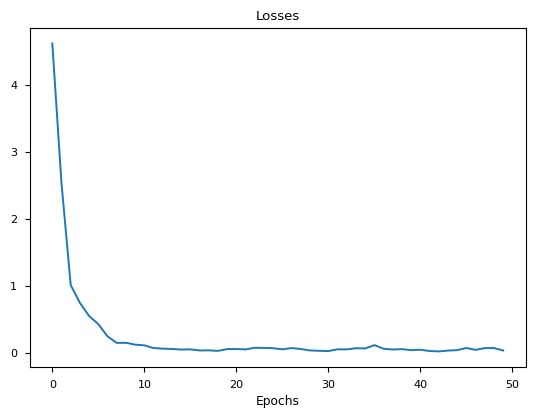

Eval loss: 2.03

(32, 'relu', 'xavier_norm', 'terminal_only', 'node', True)

0: 5.639010451196043
1: 5.148075026546529
2: 4.710554370806774
3: 4.108667152279124
4: 3.3748907404505197
5: 2.8007165911550542
6: 2.4271919586916177
7: 2.1652821212776363
8: 1.9051951958626216
9: 1.6803503656143426
10: 1.4788400316713688
11: 1.3180816148644414
12: 1.1929255718008913
13: 1.0716028107116748
14: 0.9645477398857538
15: 0.8867896572144771
16: 0.7923113977007213
17: 0.71172316561126
18: 0.6571892721163735
19: 0.5848448108176935
20: 0.5479766933378241
21: 0.500178462390912
22: 0.4412690636168146
23: 0.40609120245483793
24: 0.3660366355657474
25: 0.3369810650092914
26: 0.29961345340436835
27: 0.2719568595254382
28: 0.2585396409187892
29: 0.227671387275572
30: 0.21603076071936203
31: 0.2241262000712331
32: 0.19377947750850608
33: 0.1885870016364795
34: 0.17087876273629116
35: 0.15244427321484594
36: 0.1442994541553745
37: 0.13940177214920535
38: 0.1373154051939814
39: 0.12214855036795794
40: 0.1158431

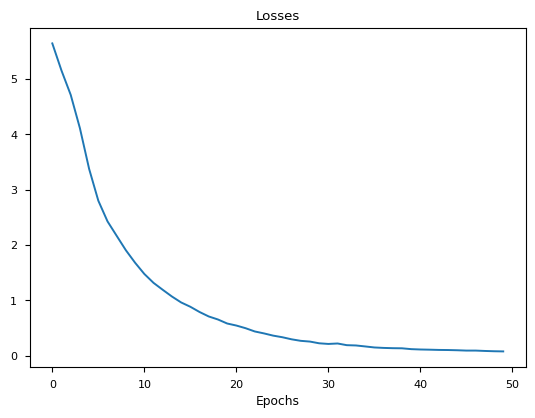

Eval loss: 2.22

(32, 'relu', 'xavier_norm', 'terminal_only', 'node', False)

0: 5.622954935493426
1: 4.939515415794916
2: 4.337287981633018
3: 3.6924746373638238
4: 3.1415843419614498
5: 2.7874003377408743
6: 2.434031783141974
7: 2.1795474520910356
8: 1.9147514799250709
9: 1.7012763978356829
10: 1.5481529134760328
11: 1.3677505228492333
12: 1.2147937517579481
13: 1.0812627520443137
14: 0.9601624913331864
15: 0.8421748292050049
16: 0.7429141429823746
17: 0.6475856974857491
18: 0.5829526170271577
19: 0.5057944088801313
20: 0.4366518510653325
21: 0.38486843490507383
22: 0.340326344191921
23: 0.29992031696131216
24: 0.26008938132381626
25: 0.23880330943394407
26: 0.2108420129443507
27: 0.19890472215256058
28: 0.18493377655005241
29: 0.16142527425126846
30: 0.17431403913797902
31: 0.16023645129773847
32: 0.13037141477490674
33: 0.11976736407450292
34: 0.12738716951155019
35: 0.11933915522483508
36: 0.09777360826941847
37: 0.09012615255219902
38: 0.0883545813066626
39: 0.08351560601053443
4

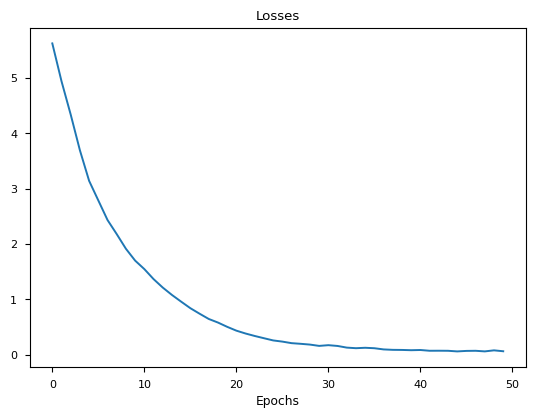

Eval loss: 2.23

(32, 'relu', 'xavier_norm', 'terminal_only', 'anode', True)

0: 5.964666172762299
1: 5.084699338326809
2: 4.199145046704388
3: 3.465205026576538
4: 2.8251891944599916
5: 2.374260363938113
6: 1.9851008828325951
7: 1.542214943361288
8: 1.1838322137708062
9: 0.8555012181787347
10: 0.5239284259837512
11: 0.2695640037019454
12: 0.20787415746682297
13: 0.19555399890679426
14: 0.1242842886923764
15: 0.09299681613366781
16: 0.09491779666249557
17: 0.07752607636966749
18: 0.07278206834658399
19: 0.06286082692720409
20: 0.048297225368078824
21: 0.04628636207316817
22: 0.04944401896021826
23: 0.043218586610656216
24: 0.038776521986103415
25: 0.03996489753657374
26: 0.042098604750259914
27: 0.03804728923157586
28: 0.05900867355380281
29: 0.05850938956187244
30: 0.030322550383757686
31: 0.04116142152800737
32: 0.04224336957947742
33: 0.03570975839749565
34: 0.03313597162267702
35: 0.044683051264203084
36: 0.025368088241155627
37: 0.02254278205291208
38: 0.03128012841476601
39: 0.03

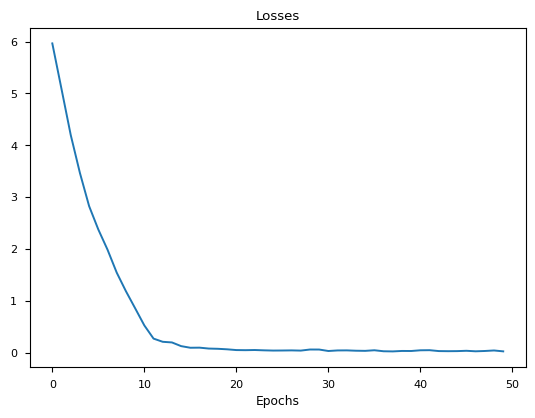

Eval loss: 2.45

(32, 'relu', 'xavier_norm', 'terminal_only', 'anode', False)

0: 8.01443808545329
1: 6.450249833588097
2: 5.203080928196351
3: 4.374508912534205
4: 3.6756039510428047
5: 3.068877703833762
6: 2.4431021079924875
7: 1.8291250028353825
8: 1.262489993097756
9: 0.7710021893782317
10: 0.3867612433906705
11: 0.3079199097933755
12: 0.19880217440272493
13: 0.16333452551278665
14: 0.1262893678370214
15: 0.10091548389060385
16: 0.07370695652511168
17: 0.05801042545196917
18: 0.06096603554137848
19: 0.05974973234684714
20: 0.038945863690405036
21: 0.040146120075494174
22: 0.06747186090513475
23: 0.04163905209450054
24: 0.03919470112492711
25: 0.03605490054329278
26: 0.034061924146425566
27: 0.027484026942598817
28: 0.03246717654784652
29: 0.02905166998195951
30: 0.02938675367081309
31: 0.03135225975604837
32: 0.045810109546853564
33: 0.042412492533108234
34: 0.03722738731397372
35: 0.032491169426292814
36: 0.02374371985738699
37: 0.03659484574072869
38: 0.026993980244354964
39: 0.0

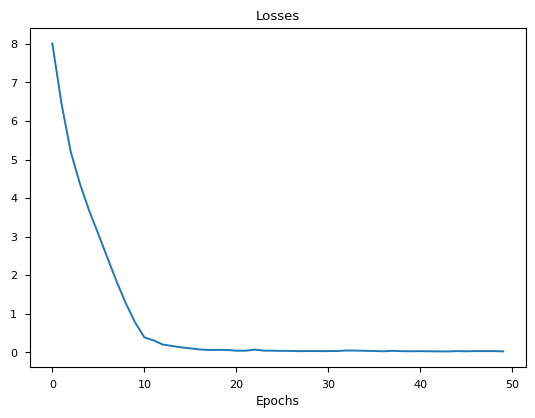

Eval loss: 2.15

(32, 'relu', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 3.991460174194312
1: 3.061154321282096
2: 2.2750432996639502
3: 1.51262255132262
4: 0.8616976326163651
5: 0.5854269775334799
6: 0.38189320540690735
7: 0.22218367417001544
8: 0.1726692491877479
9: 0.16311044694079938
10: 0.13542116721577502
11: 0.1274121973960857
12: 0.10919852535711207
13: 0.08853863016124668
14: 0.06747526473274425
15: 0.0521028217408648
16: 0.042950860276580724
17: 0.04638035636277286
18: 0.0459560235102588
19: 0.0456033156430591
20: 0.05914162350962796
21: 0.04255844022638323
22: 0.04095168910845902
23: 0.051664334224404355
24: 0.06588146957457969
25: 0.04675454701762952
26: 0.04038889358439824
27: 0.032491318021213446
28: 0.02809699907564687
29: 0.03208957609420004
30: 0.04246755501781711
31: 0.049884321595330426
32: 0.03570869246891505
33: 0.02642775841304884
34: 0.03136286226319787
35: 0.05931280736203465
36: 0.06389102797925712
37: 0.04979473031955107
38: 0.03725104348650558
39: 0.

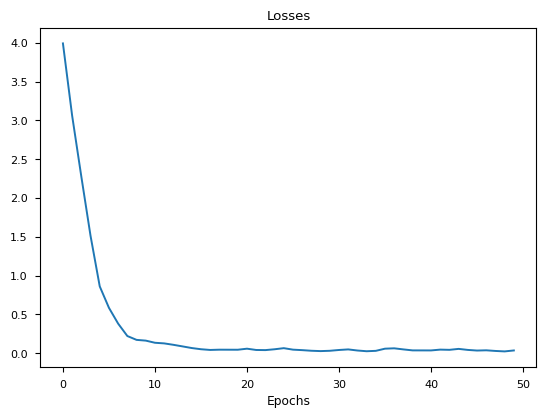

Eval loss: 2.33

(32, 'relu', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 4.5219109742803925
1: 3.28587343628852
2: 2.2336244744748748
3: 1.6223883579272942
4: 1.136640419101375
5: 0.8252225917483725
6: 0.6554113137040574
7: 0.41267076879866654
8: 0.23970708016190584
9: 0.19040273145088796
10: 0.1552805109529445
11: 0.11110752242433608
12: 0.09370217930489945
13: 0.07069307064474759
14: 0.06643658000959422
15: 0.06751960590433607
16: 0.0637447067445038
17: 0.0496997638088923
18: 0.07776572726795054
19: 0.0713764221608302
20: 0.06958561893559476
21: 0.06014020849560682
22: 0.058626654337070365
23: 0.05106282197029083
24: 0.04760752156201542
25: 0.038027492501541506
26: 0.055461529636205556
27: 0.03593545366953036
28: 0.040492017761495976
29: 0.03341303709914078
30: 0.029826369733484757
31: 0.0314443859108505
32: 0.04257627042056774
33: 0.045069108812596036
34: 0.052642396138746154
35: 0.030732857105080325
36: 0.02577665634433069
37: 0.026842543691878905
38: 0.023563742629606834

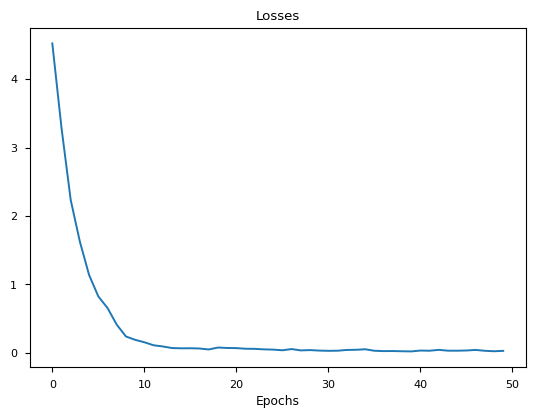

Eval loss: 2.17

(64, 'tanh', 'xavier_norm', 'terminal_only', 'node', True)

0: 6.705378165886836
1: 5.861357536533781
2: 4.996765940542193
3: 4.4390439114961815
4: 3.8150457096297443
5: 3.2242857268605167
6: 2.631734610723446
7: 2.0748840129918116
8: 1.7321224831235926
9: 1.4524093869955925
10: 1.1958427667703986
11: 0.9614580934953216
12: 0.8183365276511743
13: 0.7264013956209036
14: 0.6218431685474323
15: 0.5571219684270705
16: 0.48126003587628186
17: 0.42215880024495445
18: 0.3880398185732578
19: 0.3564660670477175
20: 0.3405408559455918
21: 0.32709777818435964
22: 0.2794132016980799
23: 0.2636138315415328
24: 0.2446661605788221
25: 0.2312919569301088
26: 0.21234512416262358
27: 0.20148418138213545
28: 0.18712879270771465
29: 0.18081415769863424
30: 0.1756330659163055
31: 0.16303574474906282
32: 0.15120775366383027
33: 0.15463609481880952
34: 0.14152401396938968
35: 0.1318500457426073
36: 0.13006867976448958
37: 0.1271982612955155
38: 0.1197994160752274
39: 0.10804275043376883
40: 

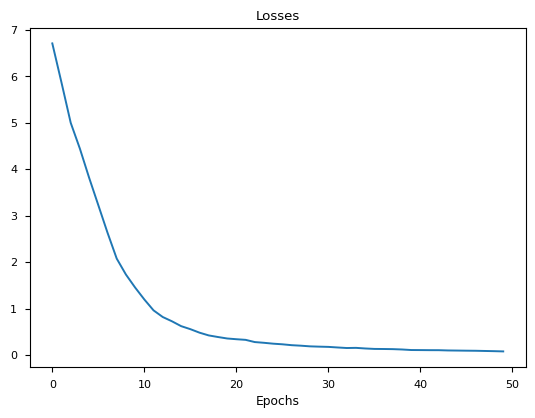

Eval loss: 2.01

(64, 'tanh', 'xavier_norm', 'terminal_only', 'node', False)

0: 10.207546509543137
1: 7.719562492410993
2: 5.984867554776746
3: 4.768066175534846
4: 3.8026614993741625
5: 3.1022133133713305
6: 2.492956112474725
7: 2.010774237054925
8: 1.6263858855388618
9: 1.397986301946209
10: 1.153276107910098
11: 0.9543480234606561
12: 0.8218083760784223
13: 0.7299013053073804
14: 0.6316812925328036
15: 0.5745686362566125
16: 0.49539075893503093
17: 0.43504361344205433
18: 0.407770741520224
19: 0.3677524904977675
20: 0.3539261058180006
21: 0.3380442577129549
22: 0.2841292683791401
23: 0.2716796968253425
24: 0.25681257655532946
25: 0.23971743277224927
26: 0.21810344779328925
27: 0.207308335992155
28: 0.1884159534435785
29: 0.18011282320887992
30: 0.17087129218072086
31: 0.1656155996078022
32: 0.15507841118987184
33: 0.153064047370946
34: 0.14211915047499302
35: 0.13386608432818628
36: 0.12526421060686532
37: 0.12059871063513851
38: 0.11670849289144372
39: 0.10874134111809337
40: 0.11

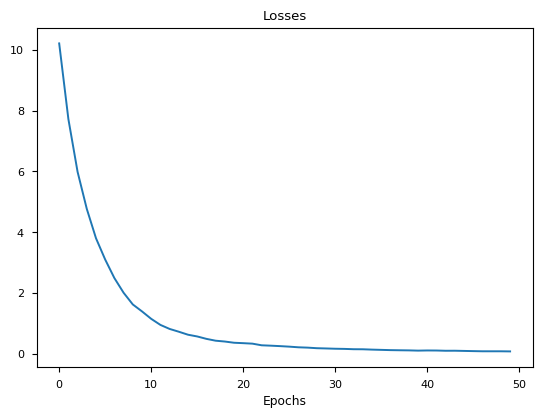

Eval loss: 2.02

(64, 'tanh', 'xavier_norm', 'terminal_only', 'anode', True)

0: 6.61109085399195
1: 6.4008261867042355
2: 6.133714831249916
3: 5.84738369439656
4: 5.417421078707031
5: 4.758041865284681
6: 4.0263436579813305
7: 3.3296120398594398
8: 2.599550908635533
9: 2.0609142977918964
10: 1.6195967398142592
11: 1.0847274271877294
12: 0.7828534539796091
13: 0.5393089433751452
14: 0.31483379841509174
15: 0.21371115357742457
16: 0.19306976198561274
17: 0.17466058620582978
18: 0.18112124014969097
19: 0.14271197665252686
20: 0.13204353002976865
21: 0.10958692222279315
22: 0.08524531030831084
23: 0.08737592406084085
24: 0.0926959770901099
25: 0.10064454031522843
26: 0.08236350919123894
27: 0.057453784019315626
28: 0.07542771544849743
29: 0.05968586021383767
30: 0.0581949071498022
31: 0.04837316921768688
32: 0.05038955515499035
33: 0.050175522303860354
34: 0.04042521634192969
35: 0.06744340441817949
36: 0.051454479178500205
37: 0.08616974491406139
38: 0.07186226745937319
39: 0.05054534493

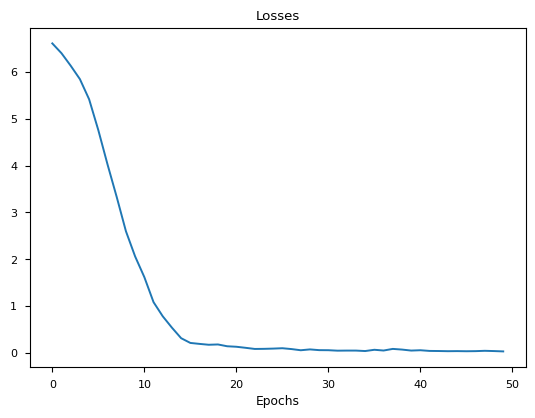

Eval loss: 1.87

(64, 'tanh', 'xavier_norm', 'terminal_only', 'anode', False)

0: 7.778507843501102
1: 6.352783950738897
2: 5.337080748997248
3: 4.463394673384097
4: 3.633759061060026
5: 2.7219015938406987
6: 1.695507588808207
7: 0.9892440937040103
8: 0.33571880848133545
9: 0.6636489267280281
10: 0.4143333994346716
11: 0.26098247495534027
12: 0.2871377130722339
13: 0.19708377927917045
14: 0.09629169861890663
15: 0.11180612847229729
16: 0.08394226320914196
17: 0.09169692759937789
18: 0.07014308882492618
19: 0.06562664014955076
20: 0.0648113112680327
21: 0.060621928278233136
22: 0.10852207889654239
23: 0.10307559399814238
24: 0.07630199274027247
25: 0.06743288892523824
26: 0.0917319509940478
27: 0.07817515307486762
28: 0.07091177088374603
29: 0.05644244190720354
30: 0.05187053155652866
31: 0.06713704531401042
32: 0.05686349453024975
33: 0.07832993096877011
34: 0.06361206736841135
35: 0.048039811213636735
36: 0.05058189685068005
37: 0.06080780604915308
38: 0.05056354678842574
39: 0.048443

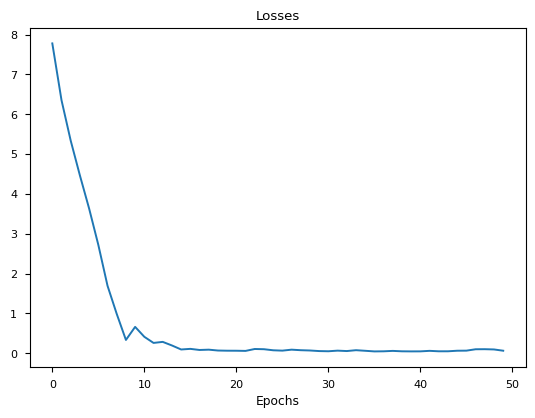

Eval loss: 1.86

(64, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 6.526649910857799
1: 6.062952255147251
2: 5.459206661959617
3: 4.743022719330217
4: 3.7829102823554743
5: 2.693039217325234
6: 2.0210744518360504
7: 1.6854486044820671
8: 1.6146164998399644
9: 1.3250743391562334
10: 0.8567901179907842
11: 0.730317574831738
12: 0.6194524273310282
13: 0.4930151577693686
14: 0.4842900318373114
15: 0.4429412475444914
16: 0.40156637387971417
17: 0.31846163714275627
18: 0.3048275658201509
19: 0.23297911999019952
20: 0.20058831916755035
21: 0.15979686855066064
22: 0.14837775165972017
23: 0.11733966734364423
24: 0.12061192661324291
25: 0.08272822439192325
26: 0.07554772593927543
27: 0.06645213133899194
28: 0.05534745700691093
29: 0.06388497275793903
30: 0.05480674196700171
31: 0.051934048644961726
32: 0.048076477109606226
33: 0.04596409244417096
34: 0.055821157314598524
35: 0.03813111901831426
36: 0.039004184211990034
37: 0.03955331466442483
38: 0.05567158890409739
39: 0.03339106

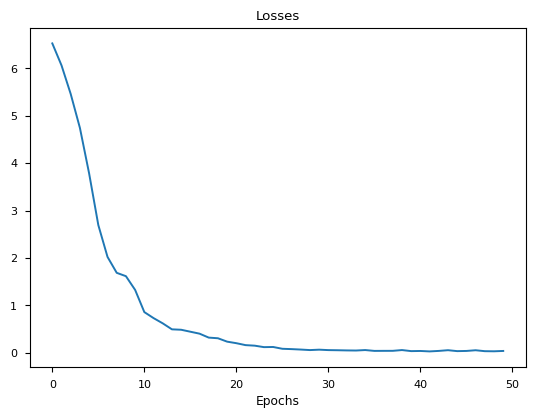

Eval loss: 1.98

(64, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 7.568230779598741
1: 6.582031142726461
2: 5.896430253595918
3: 5.039288152998451
4: 4.166546828954911
5: 3.3963595000260827
6: 2.468028895546746
7: 1.6767892500711092
8: 1.143366048955079
9: 0.41825105525222284
10: 0.5313906138852083
11: 0.44707998638556046
12: 0.35171685037452766
13: 0.3053836366046369
14: 0.23626719475949587
15: 0.20510240639344185
16: 0.11952146425856194
17: 0.11754294784731605
18: 0.07625231024382789
19: 0.07810604113568652
20: 0.09050927292645577
21: 0.08103018126577868
22: 0.0876655176851342
23: 0.057024269887781
24: 0.07866414449851165
25: 0.056694769529066616
26: 0.11318379067597112
27: 0.13651094639092742
28: 0.16750544723091915
29: 0.16609983604692027
30: 0.2521010229338079
31: 0.18472367796632874
32: 0.125407191620435
33: 0.11256189584254742
34: 0.18976269153893305
35: 0.19596864884957477
36: 0.15016757767221955
37: 0.12758357559877842
38: 0.12963954675906061
39: 0.18054065974

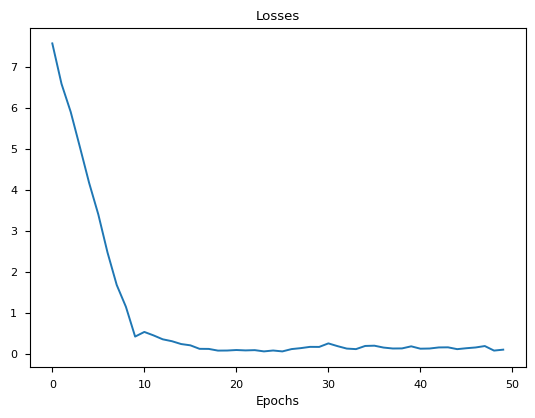

Eval loss: 2.00

(64, 'relu', 'xavier_norm', 'terminal_only', 'node', True)

0: 7.25455790263528
1: 6.964136552222273
2: 6.733097074743366
3: 6.36991736204613
4: 6.005732707250623
5: 5.670017615076839
6: 5.371520317257395
7: 4.846018748111818
8: 4.4516574267935995
9: 3.941350546610034
10: 3.461091298877286
11: 3.200026101467273
12: 3.052434639191069
13: 2.8278387793199933
14: 2.67999266324132
15: 2.571903289386286
16: 2.3064408967321106
17: 2.1246940249338198
18: 2.015694151323676
19: 1.8573025616607572
20: 1.767380705591773
21: 1.732219382153715
22: 1.557363097275485
23: 1.4561221398266597
24: 1.3885476829615713
25: 1.3410461857957365
26: 1.232676415659054
27: 1.1738878684708187
28: 1.0879598503036352
29: 1.0155297684076952
30: 0.9851911635455071
31: 0.9298485889214427
32: 0.8580903173911362
33: 0.8531416246120131
34: 0.7732183849422419
35: 0.728788462804446
36: 0.6519921510390951
37: 0.652402334983416
38: 0.6152267251759079
39: 0.5544252301611055
40: 0.5433158261432858
41: 0.51806164

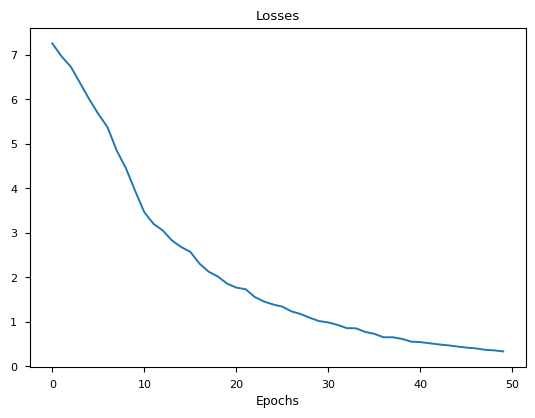

Eval loss: 2.37

(64, 'relu', 'xavier_norm', 'terminal_only', 'node', False)

0: 7.30583402632006
1: 6.591102232211281
2: 6.065945482731786
3: 5.495004148701878
4: 4.923691902738116
5: 4.405201511222731
6: 4.046358816186575
7: 3.544725667855415
8: 3.318357183007899
9: 3.0740727117097455
10: 2.8688975601193607
11: 2.614878427564078
12: 2.4034306986799434
13: 2.2551182304822563
14: 2.04625704558224
15: 1.9192460634646578
16: 1.7506009266303892
17: 1.6395251871983123
18: 1.494058327601118
19: 1.3688196059811735
20: 1.2679118524323667
21: 1.2248800703573057
22: 1.107996117306409
23: 1.0526700426139874
24: 0.9620019381580711
25: 0.9039868924136821
26: 0.8258882396103514
27: 0.7677626569820333
28: 0.7076318330040821
29: 0.6440301254458672
30: 0.6176194104575206
31: 0.581648241683447
32: 0.5284508438693412
33: 0.5026432132624055
34: 0.4636850328534985
35: 0.41443357211408416
36: 0.3866393298069162
37: 0.3626517383585732
38: 0.3355770244773924
39: 0.3043211146726708
40: 0.2878757644132758
41: 

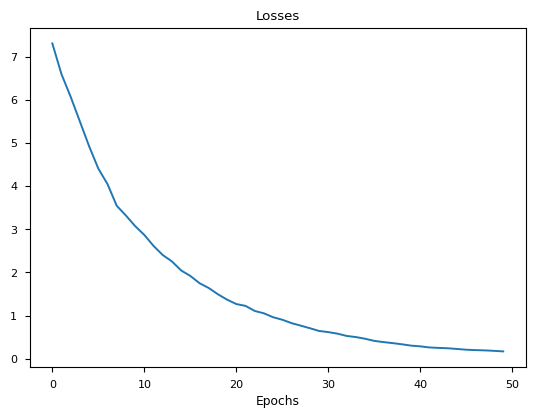

Eval loss: 2.31

(64, 'relu', 'xavier_norm', 'terminal_only', 'anode', True)

0: 6.066294597490957
1: 5.395807145025297
2: 4.848637834688076
3: 4.621834051454947
4: 4.374494162234655
5: 4.010997261378018
6: 3.6255439931767115
7: 3.426349547965236
8: 2.9920060875837384
9: 2.662450151388658
10: 2.4578156546981402
11: 2.238315881716861
12: 1.9835741191783336
13: 1.8185878061439407
14: 1.6341141145684233
15: 1.4940364582308772
16: 1.351723517612349
17: 1.2174754830935666
18: 1.1336263727746876
19: 0.9707586485923414
20: 0.8691837272575623
21: 0.7230984877689323
22: 0.5372512772045676
23: 0.4054076974282909
24: 0.3604814877600726
25: 0.3839446367489764
26: 0.3124505631377429
27: 0.2404331086998819
28: 0.21322359583889505
29: 0.2226123616225094
30: 0.1975577258361123
31: 0.18371177563969582
32: 0.15952735298013215
33: 0.15933357113047883
34: 0.1440927598897179
35: 0.17025686030992337
36: 0.18369936403259376
37: 0.1929605996614259
38: 0.14816606633490934
39: 0.11689696833490942
40: 0.12025786

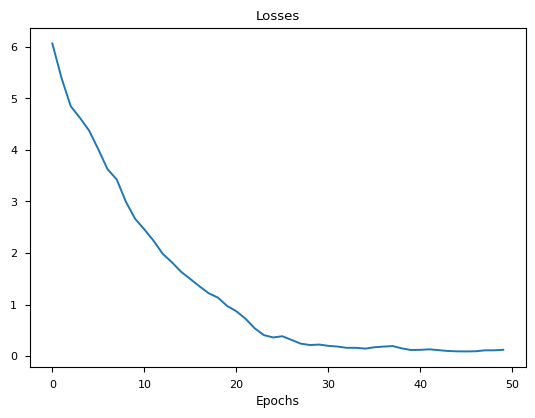

Eval loss: 2.44

(64, 'relu', 'xavier_norm', 'terminal_only', 'anode', False)

0: 8.677199933545117
1: 7.744826247323744
2: 6.962723425420689
3: 6.019198003896355
4: 5.3055110776806185
5: 4.892383627728018
6: 4.402296413047295
7: 4.061254353790045
8: 3.739445795496266
9: 3.48690688594346
10: 3.095460996576184
11: 2.796314202627741
12: 2.487784359536124
13: 2.183052709041067
14: 1.9112316983025461
15: 1.6422556910776183
16: 1.319389860952926
17: 0.9835568720298588
18: 0.7272031347818907
19: 0.5122756289002305
20: 0.43070513868814025
21: 0.33703983579750213
22: 0.19190094070707722
23: 0.16123637233429808
24: 0.1458934876309399
25: 0.12735369021167134
26: 0.10549701079741883
27: 0.09957957886665753
28: 0.08147460207094283
29: 0.0695535862587299
30: 0.06955279684355858
31: 0.05661705729775959
32: 0.05928969336821839
33: 0.05445632578873186
34: 0.050524159251241534
35: 0.04844615946021684
36: 0.058078865426436026
37: 0.060226009148163444
38: 0.06623020861940451
39: 0.05314480439527541
40: 0

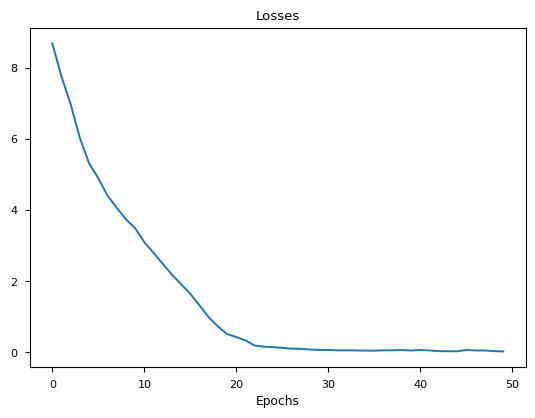

Eval loss: 2.18

(64, 'relu', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 5.4611336296499955
1: 4.539404889454956
2: 3.9358337479945424
3: 3.4924605307614294
4: 2.944641477480901
5: 2.3988345854048503
6: 1.839591819839387
7: 1.3257451491655117
8: 1.0257883692765255
9: 0.7807533559025068
10: 0.5720300492068947
11: 0.4701368900833329
12: 0.3479040244460366
13: 0.27695851228211443
14: 0.26832967651956047
15: 0.2130946029558958
16: 0.20330482219392806
17: 0.16214860429257222
18: 0.1719332986356091
19: 0.16420915642784217
20: 0.15024786374177285
21: 0.13292493380883943
22: 0.12185784668159585
23: 0.12771601505635607
24: 0.13512856927687203
25: 0.13540331854079088
26: 0.11090770160209243
27: 0.11215151284575885
28: 0.11921746369217175
29: 0.11515295899398274
30: 0.11724996701280832
31: 0.13181850873114342
32: 0.154189568932071
33: 0.10588275630288417
34: 0.11788140540984583
35: 0.11995023620968018
36: 0.12712027481820887
37: 0.1634904869359019
38: 0.19127553694253582
39: 0.1205360392

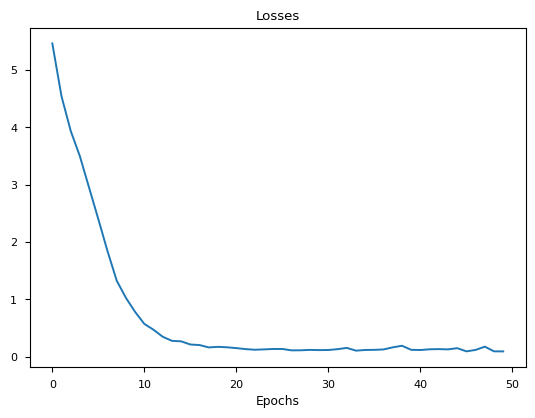

Eval loss: 2.30

(64, 'relu', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 6.422558780597698
1: 5.463441100645061
2: 4.35342214650671
3: 3.2734193284393136
4: 2.3673276380827923
5: 1.6857553103581013
6: 1.726263197988228
7: 1.474021144896565
8: 1.059866097701347
9: 0.980484669646214
10: 0.8843279521725363
11: 0.7041678112718697
12: 0.6144845617754988
13: 0.4710378154083852
14: 0.3605248596445264
15: 0.3119631425620542
16: 0.29429652781908916
17: 0.24409256966392792
18: 0.2090977592664019
19: 0.1814573284954712
20: 0.15641144112734984
21: 0.14054181645664598
22: 0.11625486393584082
23: 0.10450458784670699
24: 0.08613209517179604
25: 0.08025169035551993
26: 0.08353417202234012
27: 0.10515093848722444
28: 0.0627836096159638
29: 0.10183717972303388
30: 0.09802309691352587
31: 0.06855503920640907
32: 0.12325565531645055
33: 0.126790723876986
34: 0.1360250162731386
35: 0.1145553371911615
36: 0.08744012545146138
37: 0.07028991621202411
38: 0.06172946702128669
39: 0.04010502590859952
4

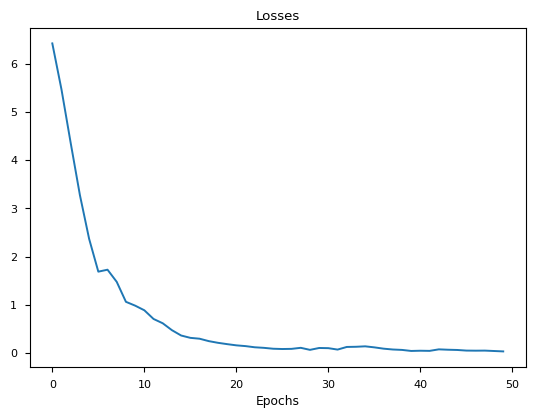

Eval loss: 2.32

(128, 'tanh', 'xavier_norm', 'terminal_only', 'node', True)

0: 16.92029664601185
1: 14.27509773046829
2: 11.93278814355113
3: 10.045791115051621
4: 8.528144978827102
5: 7.269286684051412
6: 6.241957183565814
7: 5.39548769228289
8: 4.6002130880108645
9: 4.011414620037245
10: 3.520196641159459
11: 3.0506428120150693
12: 2.6602365539970507
13: 2.351760762496513
14: 2.036274632309464
15: 1.8430479917288518
16: 1.6425731004234785
17: 1.4665155051090955
18: 1.3359754805895534
19: 1.2222236407282163
20: 1.125937914682154
21: 1.0290931915229917
22: 0.9321646604603646
23: 0.8558353342710101
24: 0.8103754263197049
25: 0.7510352035650101
26: 0.6996341054310913
27: 0.652333217490397
28: 0.6127790047479285
29: 0.5763469100345525
30: 0.550340698951497
31: 0.5145531326617723
32: 0.48788727966381157
33: 0.4704519906638901
34: 0.4385651232303085
35: 0.414771451427024
36: 0.39947513303451465
37: 0.38289405899037404
38: 0.3645500532756294
39: 0.350423793414065
40: 0.3371314932364857
41:

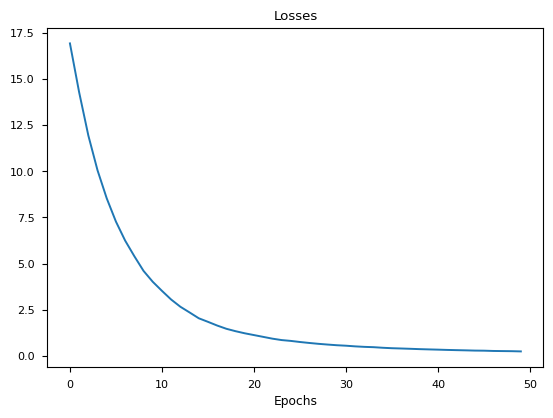

Eval loss: 2.01

(128, 'tanh', 'xavier_norm', 'terminal_only', 'node', False)

0: 11.450477681920496
1: 10.015033702097861
2: 8.795818198870467
3: 7.873284116219471
4: 7.259633428748412
5: 6.574663845167414
6: 6.073525788525627
7: 5.5717535932923585
8: 4.983930374071142
9: 4.4801320626346754
10: 4.051729880668365
11: 3.6069970546460137
12: 3.2595126795953107
13: 2.947228606238702
14: 2.583392714761943
15: 2.365819635312818
16: 2.1399146293918907
17: 1.9352018645330529
18: 1.7558010650551295
19: 1.618622675377681
20: 1.4651599637681714
21: 1.3272300230175307
22: 1.1899643161697244
23: 1.0858681684719778
24: 1.015271221189738
25: 0.9400302814278456
26: 0.868050285838186
27: 0.8019274292475479
28: 0.7375547313774765
29: 0.6881729187068033
30: 0.6570151426756766
31: 0.613587716749209
32: 0.5761706203682481
33: 0.5444591476162721
34: 0.5059077549436766
35: 0.47792731279344813
36: 0.4550072340927602
37: 0.43242221717396045
38: 0.40765597147053
39: 0.3905694456034784
40: 0.3745463796301887
41

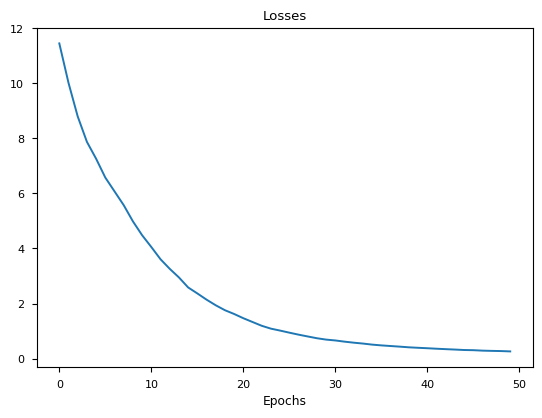

Eval loss: 2.00

(128, 'tanh', 'xavier_norm', 'terminal_only', 'anode', True)

0: 10.074283402909167
1: 8.888238263702902
2: 8.131442684484878
3: 7.634646300545195
4: 7.173994315310169
5: 6.54716881288141
6: 5.9185143276147585
7: 5.271182105613974
8: 4.558790086717273
9: 3.937173226049557
10: 3.241933951344305
11: 2.515433986882369
12: 1.8501040095915124
13: 1.1347524141769099
14: 0.4579844978278562
15: 0.43470153065487466
16: 0.6934705837179753
17: 0.8141996421715588
18: 0.7167687051844941
19: 0.4786114411840139
20: 0.2506453230396606
21: 0.21869592032689292
22: 0.30364022773126687
23: 0.32544368209082936
24: 0.31529070749661614
25: 0.2115427800863657
26: 0.1365353039675699
27: 0.1862805942654223
28: 0.22197602894297347
29: 0.19624337267297215
30: 0.13525827831451936
31: 0.09183953309589325
32: 0.12268797047463066
33: 0.1401163384054792
34: 0.10104278783998215
35: 0.09243833476334722
36: 0.11019749977427293
37: 0.10456700618140528
38: 0.09295901585383323
39: 0.09974134425802078
40: 0.

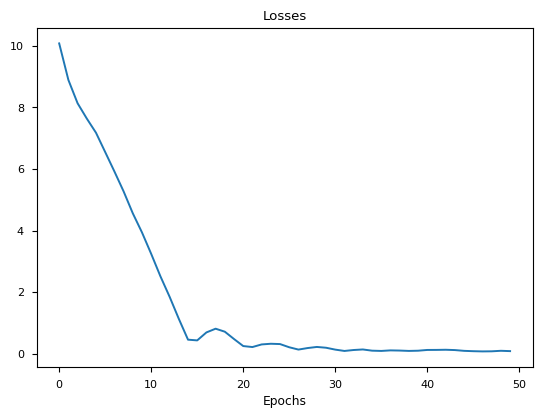

Eval loss: 2.02

(128, 'tanh', 'xavier_norm', 'terminal_only', 'anode', False)

0: 14.474407957562022
1: 12.484775944649918
2: 10.680946588214248
3: 9.141453916788556
4: 7.862898838473957
5: 7.0051322363008435
6: 6.188659022117634
7: 5.44778311370332
8: 4.780427769371237
9: 4.061044194866269
10: 3.2867404046292457
11: 2.5094552124129477
12: 1.7218318185451646
13: 1.0277997651777517
14: 0.7535464248325434
15: 0.7248868670071938
16: 0.5446444018603988
17: 0.7219709914622756
18: 0.8345163039295214
19: 0.6661323222734609
20: 0.33041136381859787
21: 0.23773823390233778
22: 0.31369983926631306
23: 0.29210262390417346
24: 0.3527111275303365
25: 0.24502194050603676
26: 0.17817364756159593
27: 0.15453187850389838
28: 0.21218001502608358
29: 0.1768675037636766
30: 0.156652769643506
31: 0.11795348641036828
32: 0.14908460746580948
33: 0.12149128315028049
34: 0.10195289809417807
35: 0.10461662973786043
36: 0.11314769143597034
37: 0.09240616078857708
38: 0.0908894356888773
39: 0.09657114730080503
40

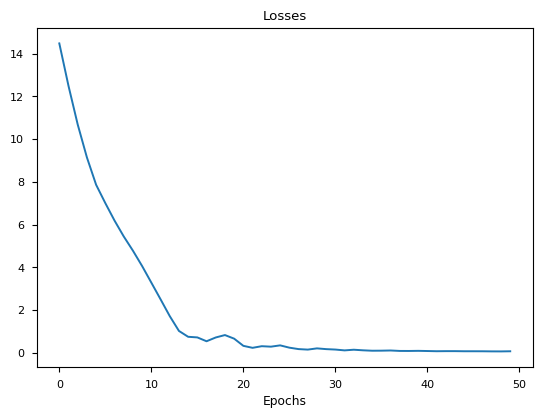

Eval loss: 1.86

(128, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 15.323884987341952
1: 13.190861057688354
2: 11.45494140394587
3: 10.079793063882324
4: 8.697297534687179
5: 7.541151267376568
6: 6.439897344427557
7: 5.471848292251474
8: 4.478138242917819
9: 3.524086935043118
10: 2.642049616367605
11: 1.7845822350211298
12: 1.2018062133861582
13: 0.9218406567251858
14: 0.9276460913848854
15: 0.9953016081187599
16: 1.0116960420249115
17: 0.9436414333573618
18: 0.813806937596771
19: 0.5893700354209714
20: 0.4595300186934207
21: 0.42944603805117615
22: 0.35559128331854095
23: 0.4087238038866456
24: 0.3605535351693956
25: 0.32050141284256606
26: 0.2622020005078734
27: 0.19380562863101874
28: 0.22555287578238628
29: 0.2074335811321135
30: 0.17204322700067276
31: 0.15681594470472693
32: 0.14416227387775724
33: 0.1507415859554574
34: 0.11068908078098252
35: 0.10701648861951396
36: 0.11040549233162854
37: 0.10696958140441709
38: 0.08742361529220305
39: 0.1047126784557991
40: 0.

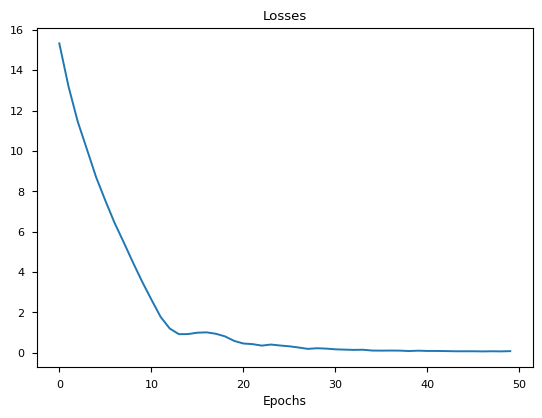

Eval loss: 1.99

(128, 'tanh', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 10.447346641980518
1: 9.227883963882658
2: 8.221063672564863
3: 7.362605928977471
4: 6.533543749689793
5: 5.581963767843999
6: 4.60731598730232
7: 3.4897726983201904
8: 2.462972334822542
9: 1.5666267918241092
10: 1.130085883197973
11: 1.0176875850377223
12: 1.0208850048814022
13: 1.2165441357086078
14: 1.2156748395398227
15: 0.9832540900856677
16: 0.6010725824423309
17: 0.4687889854812162
18: 0.5611180616123509
19: 0.5245370677288419
20: 0.4965142574056295
21: 0.4057299314596181
22: 0.21547453547651454
23: 0.29542626478473655
24: 0.2887951200648773
25: 0.22135207015060968
26: 0.14393346905835686
27: 0.19103353086566693
28: 0.17149755570004682
29: 0.12872862969140753
30: 0.13817333481830196
31: 0.13220596497854328
32: 0.1126956157737281
33: 0.12325684062191562
34: 0.1014215551889765
35: 0.09871708038248206
36: 0.1056048649752784
37: 0.08565104088288882
38: 0.09724798931679303
39: 0.08442512726022272
40: 

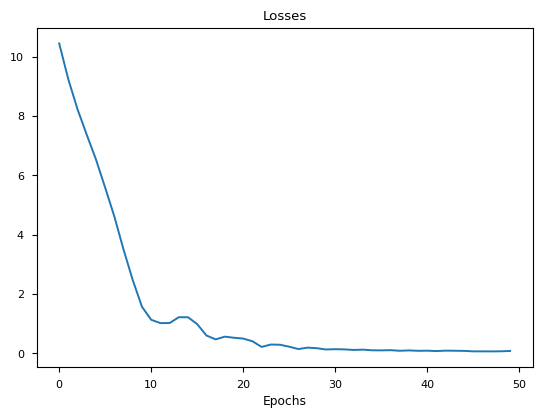

Eval loss: 2.11

(128, 'relu', 'xavier_norm', 'terminal_only', 'node', True)

0: 9.523181810857082
1: 8.992566858547557
2: 8.511347335087617
3: 8.219552178995494
4: 7.919022043981997
5: 7.5031090520546035
6: 7.162323415894743
7: 6.874237119974296
8: 6.511825155924052
9: 6.273253879137971
10: 6.005938353743433
11: 5.660870429392789
12: 5.360614747266581
13: 5.063226215472621
14: 4.809843698569162
15: 4.562785639328972
16: 4.223339325531388
17: 3.980176684110744
18: 3.778260509280937
19: 3.5089922634259354
20: 3.3449040319015753
21: 3.146743693818454
22: 2.9259278391665258
23: 2.744679075692504
24: 2.588165893546244
25: 2.4095690956677682
26: 2.2052280188286533
27: 2.083983078718262
28: 1.9383349663010172
29: 1.7888660603155864
30: 1.6528429660798682
31: 1.5275795450819674
32: 1.40813291489542
33: 1.2884301085970877
34: 1.1871427717584535
35: 1.0907029985354595
36: 1.013796836042303
37: 0.9530392173523237
38: 0.8805603088226113
39: 0.8498710877523572
40: 0.7877698381356044
41: 0.72734846

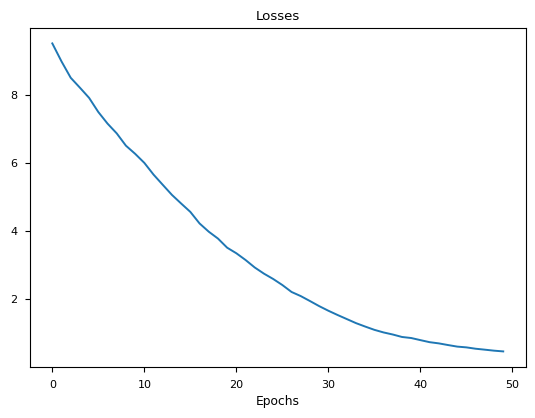

Eval loss: 2.29

(128, 'relu', 'xavier_norm', 'terminal_only', 'node', False)

0: 11.010186287668649
1: 10.794090814885285
2: 10.462602672859642
3: 10.121910634669046
4: 9.820502213092334
5: 9.56188096591871
6: 9.30049474843029
7: 9.051339352449473
8: 8.755021672150267
9: 8.477390213953594
10: 8.042745634848227
11: 7.871066491974715
12: 7.479092078623221
13: 7.212486162388517
14: 6.863302170841273
15: 6.467758085452644
16: 6.169736406026354
17: 5.892791633382581
18: 5.565999695416567
19: 5.368121340689244
20: 5.170752530227005
21: 5.005701507665684
22: 4.863396085834175
23: 4.68964321267751
24: 4.595185343366115
25: 4.389219290941043
26: 4.205191541036096
27: 4.082436336702854
28: 3.914726278685891
29: 3.742665516571068
30: 3.620794067210078
31: 3.4263764287376217
32: 3.3287624887862424
33: 3.2197063422532723
34: 3.017549224494015
35: 2.909476630796942
36: 2.8182143526100027
37: 2.740235136762492
38: 2.6257717264245723
39: 2.5206085377367935
40: 2.4496295472914125
41: 2.342602364381916

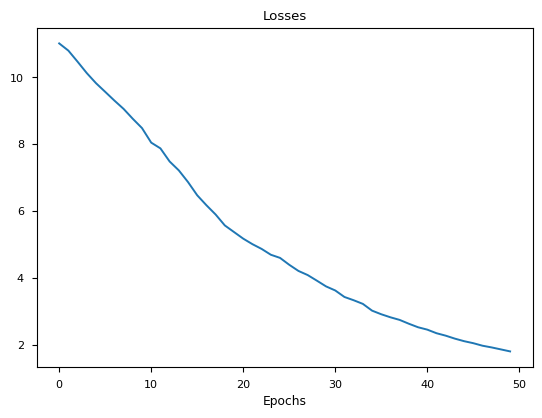

Eval loss: 2.79

(128, 'relu', 'xavier_norm', 'terminal_only', 'anode', True)

0: 10.462094013409434
1: 9.66716615606883
2: 9.133503684554139
3: 8.692480015634231
4: 8.200835806831074
5: 7.802824503869479
6: 7.3873596529807255
7: 7.120318265666957
8: 6.674506541388011
9: 6.3075909778815475
10: 6.049042350455916
11: 5.600379855771733
12: 5.324488532327591
13: 4.975821785775789
14: 4.620110646110082
15: 4.385068229554621
16: 4.104715181746224
17: 3.816707459998106
18: 3.563346347042578
19: 3.314001449313043
20: 3.085445701718456
21: 2.8501365906878195
22: 2.5755813246291237
23: 2.3137164146798135
24: 2.1505337569588105
25: 1.880897397629993
26: 1.664020417819302
27: 1.4340806120921674
28: 1.231687108715617
29: 1.0389522484043923
30: 0.8472446021936244
31: 0.6990741399680176
32: 0.5667000185301276
33: 0.45721765176762297
34: 0.3839675086696707
35: 0.3452451869227131
36: 0.3234688653997857
37: 0.30968797015923255
38: 0.2631666671534699
39: 0.22101943835105253
40: 0.19017145097144503
41: 0.

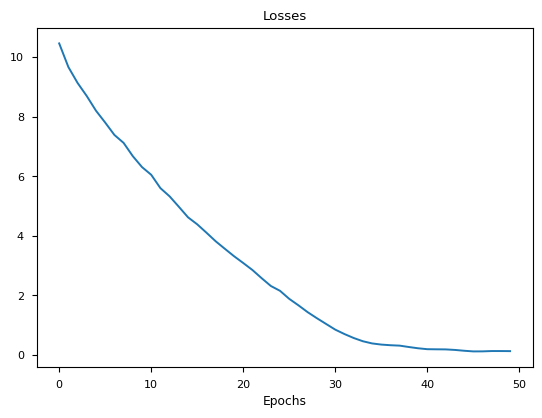

Eval loss: 2.33

(128, 'relu', 'xavier_norm', 'terminal_only', 'anode', False)

0: 9.835229670796007
1: 9.333552796045293
2: 8.964814269231624
3: 8.583987926861813
4: 8.15776574420568
5: 7.751513643407535
6: 7.302590377553038
7: 6.93246517736031
8: 6.5268078465729085
9: 6.162257508816264
10: 5.945490595783497
11: 5.593140722871373
12: 5.406274193496024
13: 5.170862717950415
14: 4.962566470411224
15: 4.777530975194545
16: 4.583582446667295
17: 4.374690527793903
18: 4.20521738875283
19: 3.9840140188814273
20: 3.8248668818361287
21: 3.6193377231903128
22: 3.4071091775791826
23: 3.2044817326319
24: 3.1333027050040645
25: 2.917865176874438
26: 2.7733077650802187
27: 2.586508365370045
28: 2.4497068497583903
29: 2.2937365128951326
30: 2.1225196184741457
31: 1.9557339742732736
32: 1.801171519080567
33: 1.6530444282534074
34: 1.4599987637488359
35: 1.2890091825049912
36: 1.134214975766014
37: 0.9550540067050011
38: 0.8088369200658311
39: 0.6821874608441336
40: 0.5625630698951496
41: 0.472207267

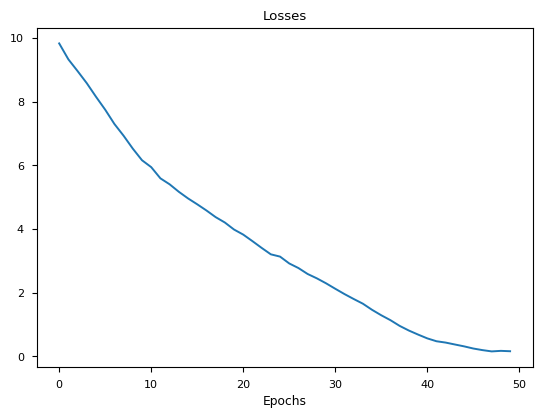

Eval loss: 2.47

(128, 'relu', 'xavier_norm', 'terminal_only', 'sonode', True)

0: 8.55509421008387
1: 7.7908592990825944
2: 7.092762548402055
3: 6.602417558533832
4: 6.05549312266701
5: 5.471978792745848
6: 4.939527168166651
7: 4.40085340065944
8: 3.8159426251259
9: 3.3255895888158533
10: 2.7815344901680046
11: 2.3368273205431835
12: 1.9532146873400702
13: 1.6768738767717921
14: 1.5232780073572147
15: 1.4541061879978674
16: 1.3610857583124032
17: 1.2796050886845611
18: 1.1195291694829244
19: 0.904952890113651
20: 0.6693094171198659
21: 0.49212645933958876
22: 0.4486520795044403
23: 0.4316602366462481
24: 0.4064173675799525
25: 0.339346380066923
26: 0.30382269970741466
27: 0.3042229880388636
28: 0.30519320208754935
29: 0.23787177943808568
30: 0.22096285670427768
31: 0.22306552234631324
32: 0.1883486961088522
33: 0.16025029774611488
34: 0.14849578950673228
35: 0.1413445935325398
36: 0.12305669738046529
37: 0.12399047489297044
38: 0.13403161012486461
39: 0.1416602457392286
40: 0.13999746

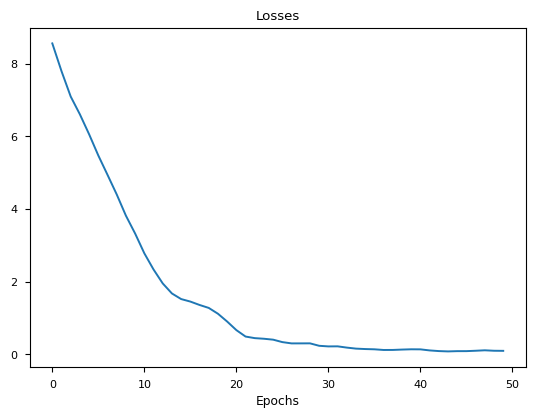

Eval loss: 2.35

(128, 'relu', 'xavier_norm', 'terminal_only', 'sonode', False)

0: 8.81543371156798
1: 8.135634804939894
2: 7.5365363858964
3: 6.993501566774248
4: 6.497627438033923
5: 5.935393783670695
6: 5.43263450790457
7: 5.058667417423475
8: 4.677292082750403
9: 4.4105644573880145
10: 4.050324932172445
11: 3.776625539609814
12: 3.503134936580997
13: 3.2960747094376646
14: 3.0360729745443447
15: 2.7706522558450537
16: 2.4953989236949843
17: 2.2922819884620234
18: 2.0259141388438087
19: 1.8132980222114967
20: 1.6335192807899492
21: 1.4852968586688196
22: 1.3406569782842102
23: 1.259282227622364
24: 1.1839346195980331
25: 1.1034298049799751
26: 1.0378891294856898
27: 0.9416048450134502
28: 0.8576514444252737
29: 0.758965536725388
30: 0.6495325038209259
31: 0.5518872294010473
32: 0.4577151577295385
33: 0.39084188041294
34: 0.32128457470844185
35: 0.29717174317160544
36: 0.2766008833612778
37: 0.26510888730901616
38: 0.2413572695428793
39: 0.23553614343375304
40: 0.2327337765605353
41

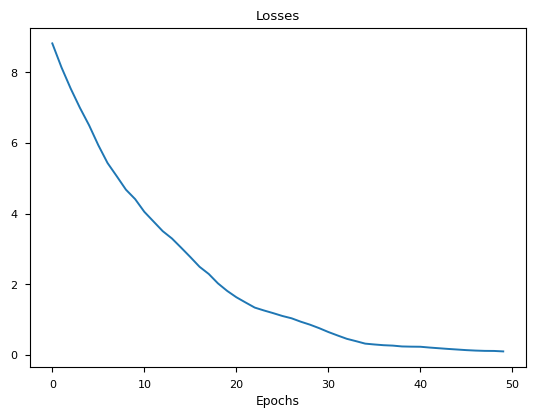

Eval loss: 2.38


In [19]:
results = {}
for param_set in itertools.product(batch_sizes, activations, initializers.keys(), losses.keys(), models, adjoints):
    print(f"\n{param_set}\n")
    bs, activ, init, loss, model, adjoint = param_set
    tf.random.set_seed(0)
    tf.keras.backend.clear_session()
    gc.collect()
    dxdt, encoder, decoder = create_model(model, activ, initializers[init])
    duration_s, loss = experiment(dxdt, losses[loss], None, terminal_only_loss, encoder, decoder, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=bs, adjoint=adjoint, plot_rate=0)
    results[param_set] = (duration_s, loss)

In [20]:
table = """
| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
"""

best_set = min(results.items(), key=lambda i: i[1][1])[0]

for params, (duration_s, eval_loss) in results.items():
    bs, activ, init, loss, model, adjoint = params
    if params is not best_set:
        table += f"| {model} | {activ} | {init} | {loss} | {bs} | {adjoint} | {duration_s:.2f} | {eval_loss:.2f} |\n"
    else:
        table += f"| {model} | {activ} | {init} | {loss} | {bs} | {adjoint} | {duration_s:.2f} | <b>{eval_loss:.2f}</b> |\n"

display(Markdown(table))


| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
| node | tanh | xavier_norm | terminal_only | 32 | True | 907.40 | 1.99 |
| node | tanh | xavier_norm | terminal_only | 32 | False | 916.44 | 2.03 |
| anode | tanh | xavier_norm | terminal_only | 32 | True | 900.80 | 1.95 |
| anode | tanh | xavier_norm | terminal_only | 32 | False | 918.59 | 2.00 |
| sonode | tanh | xavier_norm | terminal_only | 32 | True | 924.80 | 2.18 |
| sonode | tanh | xavier_norm | terminal_only | 32 | False | 946.42 | 2.03 |
| node | relu | xavier_norm | terminal_only | 32 | True | 907.54 | 2.22 |
| node | relu | xavier_norm | terminal_only | 32 | False | 923.70 | 2.23 |
| anode | relu | xavier_norm | terminal_only | 32 | True | 900.53 | 2.45 |
| anode | relu | xavier_norm | terminal_only | 32 | False | 927.11 | 2.15 |
| sonode | relu | xavier_norm | terminal_only | 32 | True | 922.78 | 2.33 |
| sonode | relu | xavier_norm | terminal_only | 32 | False | 947.42 | 2.17 |
| node | tanh | xavier_norm | terminal_only | 64 | True | 532.11 | 2.01 |
| node | tanh | xavier_norm | terminal_only | 64 | False | 552.68 | 2.02 |
| anode | tanh | xavier_norm | terminal_only | 64 | True | 533.54 | 1.87 |
| anode | tanh | xavier_norm | terminal_only | 64 | False | 537.26 | 1.86 |
| sonode | tanh | xavier_norm | terminal_only | 64 | True | 547.36 | 1.98 |
| sonode | tanh | xavier_norm | terminal_only | 64 | False | 554.35 | 2.00 |
| node | relu | xavier_norm | terminal_only | 64 | True | 525.50 | 2.37 |
| node | relu | xavier_norm | terminal_only | 64 | False | 559.43 | 2.31 |
| anode | relu | xavier_norm | terminal_only | 64 | True | 531.80 | 2.44 |
| anode | relu | xavier_norm | terminal_only | 64 | False | 542.68 | 2.18 |
| sonode | relu | xavier_norm | terminal_only | 64 | True | 540.11 | 2.30 |
| sonode | relu | xavier_norm | terminal_only | 64 | False | 587.47 | 2.32 |
| node | tanh | xavier_norm | terminal_only | 128 | True | 276.38 | 2.01 |
| node | tanh | xavier_norm | terminal_only | 128 | False | 272.80 | 2.00 |
| anode | tanh | xavier_norm | terminal_only | 128 | True | 277.66 | 2.02 |
| anode | tanh | xavier_norm | terminal_only | 128 | False | 274.37 | <b>1.86</b> |
| sonode | tanh | xavier_norm | terminal_only | 128 | True | 282.42 | 1.99 |
| sonode | tanh | xavier_norm | terminal_only | 128 | False | 285.82 | 2.11 |
| node | relu | xavier_norm | terminal_only | 128 | True | 264.73 | 2.29 |
| node | relu | xavier_norm | terminal_only | 128 | False | 270.47 | 2.79 |
| anode | relu | xavier_norm | terminal_only | 128 | True | 267.55 | 2.33 |
| anode | relu | xavier_norm | terminal_only | 128 | False | 271.38 | 2.47 |
| sonode | relu | xavier_norm | terminal_only | 128 | True | 275.39 | 2.35 |
| sonode | relu | xavier_norm | terminal_only | 128 | False | 279.13 | 2.38 |
